In this notebook we will use the boundary exploration algorithm to fully explore the parameter space of a generic Markov chain.

Last updated by: Jonathan Liu, 10/22/2020

In [1]:
#Import necessary packages
%matplotlib inline
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import scipy.special as sps
from IPython.core.debugger import set_trace
from numba import njit, prange
import numba as numba
from datetime import date
import time as Time


#Set number of threads
numba.set_num_threads(28)

In [2]:
#Simulation for calculating onset times for a generic Markov chain
#This function is now deprecated since the Gillespie algorithm is much more accurate and efficient

def CalculatetOn_GenericMarkovChain(time,dt,Q,n,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using finite timesteps and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

# Inputs:
#   time: simulation time vector
#   dt: simulation timestep
#   Q: 3D transition rate matrix, where q_kji is the transition rate at time k from state i to j for i =/= j and 
#      q_kii is the sum of transition rates out of state i
#   n: number of states
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.empty(N_cells) #Time to transition to final ON state for each cell
    t_on[:] = np.nan
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell
    finished_states = np.zeros(N_cells, dtype=int) #Vector storing finished statuses of each cell

    ## Run simulation
    #Loop over time
    #q = waitbar(0,'Running simulation...')
    for i in range(len(time)):
        if np.sum(finished_states) == N_cells: #If all cells have turned on, stop the simulation
            #print('Halting simulation since all cells have turned on.')
            break
        
        #Simulate binomial random variable to see if each cell has transitioned
        #If the input transition rate is a nan, this will manifest as never
        #transitioning.
        
        #Find indices of that have not finished yet
        incompleteCells = np.transpose(np.where(finished_states != 1))
        #Loop over cells
        for j in incompleteCells:
            #The probability that a state i switches is given by -Q_ii * dt
            p = -Q[i,state[j],state[j]] * dt #Probability of transition at this timestep for this cell
            transitioned = np.random.binomial(1,p,1) #Binary transition decision for this cell

            #The state to transition to is given by the ratio of the individual rates in the column j over the total rate -Q_ii
            if transitioned == 1:
                Q_temp = np.copy(Q) #Temporary matrix where we will remove Q_ii for this cell and state
                Q_temp[i,state[j],state[j]] = 0
                pState = np.squeeze(Q_temp[i,:,state[j]]/-Q[i,state[j],state[j]])
                #print(Q[i,:,:])
                newState = np.random.choice(n, 1, p=pState)
                #print('cell ' + str(j) + ' transitioned from state ' + str(state[j]) + \
                #      ' to state ' + str(newState) + 'at time ' + str(time[i]))                
                state[j] = newState
                
                #Record the time if it transitioned to the new state
                if newState == n-1:
                    t_on[j] = time[i]

        #See if any states have reached the ON state
        finished_states[state == n-1] = 1
    return t_on

In [8]:
#Function to generate a random transition matrix for a generic Markov chain with n states, and an irreversible
#transition into the final state.

#Inputs:
#   n: number of states
#   k_min: minimum transition rate
#   k_max: maximum transition rate

#pseudocode
#generate 2D matrix based on n
#loop over each index, if indices are connected by 1 then generate a value (except final state)
#Calculate diagonal elements from summing columns to zero
#

def MakeRandomTransitionMatrix(n, k_min, k_max):
    #Initialize the transition matrix
    Q = np.zeros((n,n))
    
    #Loop through transition indices (note that the final column is all zeros since it's an absorbing state)
    for i in range(n):
        for j in range(n-1):
            #If the indices are exactly one apart (i.e. adjacent states), then make a transition rate
            if np.abs(i-j) == 1:
                Q[i,j] = np.random.uniform(k_min,k_max)

    #Calculate the diagonal elements by taking the negative of the sum of the column
    for i in range(n-1):
        Q[i,i] = -np.sum(Q[:,i])
        
    return Q


In [9]:
#Function to mutate a transition matrix for a generic Markov chain with an irreversible transition
#into the final absorbing state. For each element in Q, the function picks a random number between
#[1-s,1+s] and multiplies it with the element

#Inputs:
#   Q: n x n transition matrix, where n is the number of states
#   s: mutation factor (q_ij -> q_ij * s)

def MutateTransitionMatrix(Q,s):
    #Loop over transition matrix indices
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            #Adjacent states
            if i != j:
                Q[i,j] = Q[i,j] * np.random.uniform(1-s,1+s)
            #Reset the diagonals to zero
            elif i == j:
                Q[i,j] = 0
    #Recalculate the diagonal entries
    for i in range(Q.shape[0]-1):
        Q[i,i] = -np.sum(Q[:,i])
    return Q

In [4]:
#Simulation for calculating onset times for a generic Markov chain using Gillespie algorithm
#Using vectorized formulation for faster speed

def CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using the Gillespie algorithm and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

#For now, this only works with steady transition rates. Later we will modify this to account 
#for time-varying rates.

# Inputs:
#   Q: transition rate matrix, where q_ji is the transition rate from state i to j for i =/= j and 
#      q_ii is the sum of transition rates out of state i
#   n: number of states
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.zeros(N_cells) #Time to transition to final ON state for each cell
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell

    ## Run simulation
    # We will simulate waiting times for each transition for each cell and stop once each cell has
    # reached the final state
    
    #Set diagonal entries in transition matrix to nan since self transitions don't count
    for i in range(n):
        Q[i,i] = 0
    
    #Construct the transition vector out of each cell's current state
    Q_states = np.zeros((N_cells,n))
    while np.sum(state) < (n-1)*N_cells:
        Q_states = np.transpose(Q[:,state])
            
        #Generate random numbers in [0,1] for each cell
        randNums = np.random.random(Q_states.shape)

        #Calculate waiting times for each entry in the transition matrix
        #Make sure to suppress divide by zero warning
        with np.errstate(divide='ignore'):
            tau = (1/Q_states) * np.log(1/randNums)

        #Find the shortest waiting time to figure out which state we transitioned to for each cell
        tau_min = np.amin(tau, axis=1)
        newState = np.argmin(tau, axis=1)
        
        #Replace infinities with zero, corresponding to having reached the final state
        newState[tau_min==np.inf] = n-1
        tau_min[tau_min==np.inf] = 0
        
        #Update the state and add the waiting time to the overall waiting time
        state = newState
        t_on += tau_min
    return t_on

In [65]:
#Simulation for calculating onset times for a generic Markov chain using Gillespie algorithm
#Using vectorized formulation for faster speed

def CalculatetOn_GenericMarkovChainGillespieTime(Q,n,t_d,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using the Gillespie algorithm and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

#This considers time-dependent transition rates parameterized by a diffusion timescale t_d.
#The time-dependent rate has the form r ~ (1 - exp(-t/t_d)). For now, we assume only the forwards
#rates have the time-dependent profile, and that backwards rates are time-independent.

# Inputs:
#   Q: 3D transition rate matrix, where q_kji is the transition rate at time k from state i to j for i =/= j and 
#      q_kii is the sum of transition rates out of state i
#   n: number of states
#   t_d: diffusion timescale of time-dependent transition rate
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.zeros(N_cells) #Time to transition to final ON state for each cell
    time = np.zeros(N_cells) #Vector of current time for each cell
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell

    ## Run simulation
    # We will simulate waiting times for each transition for each cell and stop once each cell has
    # reached the final state
    
    #Set diagonal entries in transition matrix to nan since self transitions don't count
    for i in range(n):
        Q[i,i] = 0
        
    #Define the diffusion timescale matrix t_d (finite for forwards rates, effectively 0 for backwards rates)
    t_d_mat = np.zeros((n,n))
    t_d_mat[:,:] = 0.00000001 #Non forwards transitions are essentially 0 diffusive timescale
    for i in range(n):
        for j in range(n-1):
            #Forwards rates
            if i == j + 1:
                t_d_mat[i,j] = t_d
    
    #Construct the transition vector out of each cell's current state
    Q_states = np.zeros((N_cells,n))
    #Construct the diffusion timescale vector for each cell
    t_d_states = np.zeros((N_cells,n))
    while np.sum(state) < (n-1)*N_cells:
        Q_states = np.transpose(Q[:,state])
        t_d_states = np.transpose(t_d_mat[:,state])
        
        #Construct the current time vector for each cell
        time_states = np.transpose(np.tile(time,(n,1)))
        
            
        #Generate random numbers in [0,1] for each cell
        randNums = np.random.random(Q_states.shape)

        #Calculate waiting times for each entry in the transition matrix
        #Make sure to suppress divide by zero warning
        
        #For the exponential profile, this uses the lambertw/productlog function. The steady-state
        #case corresponds to t_d -> 0.
        with np.errstate(divide='ignore', invalid='ignore'):
            #Temp variables for readability
            a = 1/Q_states * np.log(1/randNums)
            b = -np.exp(-(a + t_d_states * np.exp(-time_states/t_d_states) + time_states)/t_d_states)
            tau = np.real(t_d_states * sps.lambertw(b) + a + t_d_states *\
                          np.exp(-time_states / t_d_states))
        #Find the shortest waiting time to figure out which state we transitioned to for each cell
        tau_min = np.amin(tau, axis=1)
        newState = np.argmin(tau, axis=1)
        
        #Replace infinities with zero, corresponding to having reached the final state
        newState[tau_min==np.inf] = n-1
        tau_min[tau_min==np.inf] = 0
        
        #Update the state and add the waiting time to the overall waiting time
        state = newState
        t_on += tau_min
        time += tau_min
    return t_on

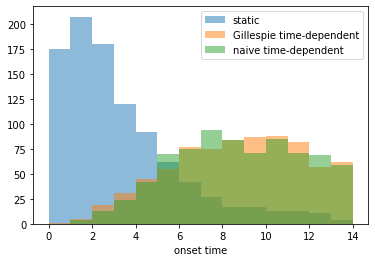

In [97]:
#Verify time-dependent Gillespie algorithm with naive algorithm
n = 4
k_min = 0.5
k_max = 5
Q = MakeRandomTransitionMatrix(n,k_min,k_max)
N_cells = 1000
t_d = 7
dt = 0.1
time = np.arange(0,20,dt)

#Construct the time-dependent transition matrix for the naive simulation
Q_timedep = np.zeros((len(time),n,n))
for i in range(len(time)):
    for j in range(n):
        for k in range(n):
            if j == k + 1:
                Q_timedep[i,j,k] = Q[j,k] * (1 - np.exp(-time[i]/t_d))
            elif j == k:
                Q_timedep[i,j,k] = 0
            else:
                Q_timedep[i,j,k] = Q[j,k]
#Fix the diagonal entries
for i in range(len(time)):
    for j in range(n):
        Q_timedep[i,j,j] = -np.sum(Q_timedep[i,:,j])
            
t_on_static = CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
t_on_timedep =  CalculatetOn_GenericMarkovChainGillespieTime(Q,n,t_d,N_cells)
t_on_naive = CalculatetOn_GenericMarkovChain(time,dt,Q_timedep,n,N_cells)

#Plot distribution
bins = np.arange(0,15,1)
plt.figure()
plt.hist(t_on_static,bins=bins,label='static',alpha=0.5)
plt.hist(t_on_timedep,bins=bins,label='Gillespie time-dependent',alpha=0.5)
plt.hist(t_on_naive,bins=bins,label='naive time-dependent',alpha=0.5)
plt.xlabel('onset time')
plt.legend()


# Parameter sweeping of Markov chain model
We're going to test the n=3 model, which has 3 free parameters, using the ideal limit of equal, irreversible rates, and considering small deviations in the form of backward rates.

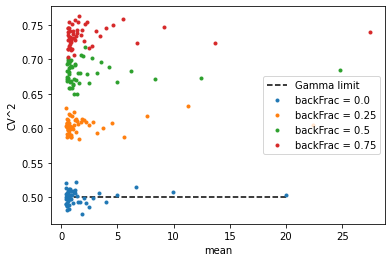

In [103]:
# Parameter sweep
n = 3
k_min = 0.1
k_max = 5.1
k_step = 0.1
k_range = np.arange(k_min,k_max,k_step)
N_cells = 10000
dt = 0.1
time = np.arange(0,50,dt)

#Small deviation from ideal Gamma limit
k_backFrac = np.arange(0,1,0.25) #Fraction backwards/forwards transition
means_dev = np.zeros((len(k_range),len(k_backFrac)))
CV2s_dev = np.zeros((len(k_range),len(k_backFrac)))

for i in range(len(k_range)):
    for j in range(len(k_backFrac)):
        Q = np.array([[-k_range[i],k_range[i]*k_backFrac[j],0],\
                      [k_range[i],-(k_range[i]+k_range[i]*k_backFrac[j]),0],\
                              [0,k_range[i],0]])
        t_on =  CalculatetOn_GenericMarkovChainGillespie(Q,n,N_cells)
        means_dev[i,j] = np.mean(t_on)
        CV2s_dev[i,j] = np.var(t_on) / np.mean(t_on)**2
            
#Plot results
plt.figure()
plt.plot((n-1)/k_range,(1/(n-1))*np.ones(k_range.shape),'k--',label='Gamma limit')
for i in range(len(k_backFrac)):
    plt.plot(means_dev[:,i],CV2s_dev[:,i],'.',label='backFrac = ' + str(k_backFrac[i]))
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.legend()

It looks like the effect of increasing the backwards rates is to increase noise independent of mean, as expected.

In [400]:
print(sps.lambertw(0))
print(sps.lambertw(0.00001))
print(sps.lambertw(np.exp(-0)))

0j
(9.999900001499974e-06+0j)
(0.5671432904097838+0j)


In [134]:
#Boundary exploration algorithm

#This function explores the 2D mean-CV2 space for a given model by following the same
#procedure as Eck et. al. 2020 (eLife). Briefly, it lays down a random parameter set, then
#slices the space into vertical and horizontal slices, finding the extremal points in each slice.
#It then mutates the parameter values for these points and recalculates the parameter space.
#This iterates until the total number of iterations has passed. The function keeps track
#of the boundary parameter values, as well as the means, CV2s, and overall parameter space areas.

#The models are generic Markov chains with nearest-neighbor transitions, and an irreversible transition
#into the final state.

#For now we are only considering the steady state
def BoundaryExploration(n_initial,iterations,slices,n_states,s,k_start,k_min,k_max,mean_max,\
                        N_cells,plots=True):
    #Inputs:
    #   n_initial: number of initial points
    #   iterations: number of iterations
    #   slices: number of horizontal or vertical slices
    #   n_states: number of Markov chain states
    #   s: mutation growth factor (should be > 1)
    #   k_start: starting mean value for transition rates
    #   k_min: minimum transition rate
    #   k_max: maximum transition rate
    #   mean_meax: maximum bound on mean onset time
    #   T: simulation end time
    #   dt: simulation timestep
    #   N_cells: number of cells in each simulation
    #   plots: Boolean to display plots (true by default)


    #Generate initial set of simulated data with random parameters.
    
    #Initialize with nan arrays
    mean_onset_total = np.zeros(n_initial) #Mean t_on values
    CV2_onset_total = np.zeros(n_initial) #CV2iance t_on values
    Q_values_total = np.zeros((n_initial,n_states,n_states)) #Transition matrices
    
    mean_onset_total[:] = np.nan
    CV2_onset_total[:] = np.nan
    Q_values_total[:,:,:] = np.nan
    
    area_total = [] #Area of boundary

    for i in prange(n_initial):
        print('Initializing point ' + str(i+1) + ' of ' + str(n_initial), end='\r')

        #Initialize input parameters randomly.
        #Create transition rates around the starting value with 25% width
        k_min_start = k_start * 0.5
        k_max_start = k_start * 1.5
        Q = MakeRandomTransitionMatrix(n_states,k_min_start,k_max_start)

        #Simulate the data with these parameters.
        t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n_states,N_cells)

        #If there aren't at least 100 samples, skip this simulation
        if np.sum(np.invert(np.isnan(t_on))) < 100:
            continue
            
        #Calculate mean and CV2
        mean_onset = np.nanmean(t_on)
        CV2_onset = np.nanvar(t_on)/np.nanmean(t_on)**2
        
        #If mean is outside bounds, skip
        if mean_onset > mean_max:
            continue

        #Save the results
        mean_onset_total[i] = mean_onset
        CV2_onset_total[i] = CV2_onset
        Q_values_total[i,:,:] = Q

    #Calculate the boundary
    
    #Remove nans
    noNanInd = np.invert(np.isnan(mean_onset_total)) #Indices of nans
    mean_onset_total = mean_onset_total[noNanInd]
    CV2_onset_total = CV2_onset_total[noNanInd]
    Q_values_total = Q_values_total[noNanInd,:,:]
    
    #Convex hulls
    points = np.transpose(np.array([mean_onset_total,CV2_onset_total]))
    hull = ConvexHull(points)

    area_total.append(hull.area) #Save the area of the convex hull
    vertices = hull.vertices #Indices of the points on the convex hull

    #Keep only boundary points
    #mean_onset_total = mean_onset_total[vertices]
    #CV2_onset_total = CV2_onset_total[vertices]
    #Q_values_total = Q_values_total[vertices]

    #Plot results
    if plots:
        plt.close('all')
        plt.figure('boundaryExploration')
        plt.plot(mean_onset_total,CV2_onset_total,'b.',label='initial set')
        plt.xlabel('mean onset time')
        plt.ylabel('CV2 onset time')
        plt.title('Boundary exploration')
        plt.legend()
        

        plt.figure('areaGrowth')
        plt.plot(area_total,'r.-',label='boundary area')
        plt.legend()
        

    #Generate new parameter values using the boundary. Divide the initial
    #region into horizontal and vertical slices (number of slices given by
    #function input). Within each horizontal/vertical slice, the two points with the
    #most extreme mean/CV2 in onset time are found. A new point is
    #generated for each of these points with parameter values in a neighborhood
    #of the "seed" datapoint. This neighborhood is "tighter"
    #than the range of possible values for the initial set so that we can
    #efficiently determine the boundary of the possible parameter space. The
    #advantage of using this slice technique is that the boundary sampling is
    #not biased towards regions of higher density.
    print('')
    for j in range(iterations):
        print('Iteration ' + str(j+1) + ' of ' + str(iterations), end='\r')
        #Calculate slices in mean onset time
        min_mean_onset = mean_onset_total.min()
        max_mean_onset = mean_onset_total.max()
        mean_onset_slice_values = np.linspace(min_mean_onset,max_mean_onset,slices+1) #slices
        
        #Continue to next iteration if this set has no range in the mean onset
        if len(mean_onset_slice_values) == 0:
            continue
        
        #Calculate slices in CV2 onset time
        min_CV2_onset = CV2_onset_total.min()
        max_CV2_onset = CV2_onset_total.max()
        CV2_onset_slice_values = np.linspace(min_CV2_onset,max_CV2_onset,slices+1) #slices
        
        #Continue to next iteration if this set has no range in the CV2 onset
        if len(CV2_onset_slice_values) == 0:
            continue

        #Loop through slices
        newpoints = 1 #Number of new points for each extremal point
        mean_onset_slice = np.zeros((slices,newpoints*4))
        CV2_onset_slice = np.zeros((slices,newpoints*4))
        Q_values_slice = np.zeros((slices,newpoints*4,n_states,n_states))
        
        mean_onset_slice[:,:] = np.nan
        CV2_onset_slice[:,:] = np.nan
        Q_values_slice[:,:,:,:] = np.nan

        for i in prange(slices):
            #print('Iteration ' + str(j+1) + ' of ' + str(iterations) + \
            #    ', slice ' + str(i+1) + ' of ' + str(slices), end='\r')
            #Identify extremal points within slices (4 maximum extremal points
            #per iteration for the max/min for CV2_onset/t_on spread)
            p = 1 #Counter to keep track of new points

            #Keep track of new points for each parallel loop
            mean_onset_p = np.zeros(newpoints*4)
            CV2_onset_p = np.zeros(newpoints*4)
            Q_values_p = np.zeros((newpoints*4,n_states,n_states))
            
            mean_onset_p[:] = np.nan
            CV2_onset_p[:] = np.nan
            Q_values_p[:] = np.nan

            for p in range(newpoints*4):
                if p <= (newpoints*1):
                    index = np.intersect1d(np.where(mean_onset_total >= mean_onset_slice_values[i]),\
                                          np.where(mean_onset_total <= mean_onset_slice_values[i+1]))
                    if len(index) == 0:
                        continue
                    else:
                        index = np.where(CV2_onset_total[index] == CV2_onset_total[index].min()) #Find index of minimum CV2_onset point
                elif p <= (newpoints*2):
                    index = np.intersect1d(np.where(mean_onset_total >= mean_onset_slice_values[i]),\
                                          np.where(mean_onset_total <= mean_onset_slice_values[i+1]))
                    if len(index) == 0:
                        continue
                    else:
                        index = np.where(CV2_onset_total[index] == CV2_onset_total[index].max()) #Find index of maximum CV2_onset point      
                elif p <= (newpoints*3):
                    index = np.intersect1d(np.where(CV2_onset_total >= CV2_onset_slice_values[i]),\
                                          np.where(CV2_onset_total <= CV2_onset_slice_values[i+1]))
                    if len(index) == 0:
                        continue
                    else:
                        index = np.where(mean_onset_total[index] == mean_onset_total[index].min()) #Find index of minumum mean_onset point
                elif p <= (newpoints*4):
                    np.intersect1d(np.where(CV2_onset_total >= CV2_onset_slice_values[i]),\
                                          np.where(CV2_onset_total <= CV2_onset_slice_values[i+1]))
                    if len(index) == 0:
                        continue
                    else:
                        index = np.where(mean_onset_total[index] == mean_onset_total[index].max()) #Find index of maximum mean_onset point
                #If no point found, continue
                if len(index) == 0:
                    continue
                #If multiple extremal indices found, keep the first one
                if len(index) > 1:
                    index = index[0]

                #Generate new points.
                Q = MutateTransitionMatrix(np.squeeze(Q_values_total[index,:,:]),s)

                #Check to see that new parameters lie within parameter bounds.
                #JL 10/22/2020: Update this to repeat simulations until we get something within bounds
                c = 0
                for i in range(n_states):
                    for j in range(n_states):
                        if i != j and Q[i,j] != 0 and (Q[i,j] < k_min or Q[i,j] > k_max):
                            c = 1
                if c == 1:
                    continue

                #Simulate the data with these parameters.
                t_on = CalculatetOn_GenericMarkovChainGillespie(Q,n_states,N_cells)

                #If there aren't at least 100 samples, skip this simulation
                if np.sum(np.invert(np.isnan(t_on))) < 100:
                    continue

                #Calculate mean and CV2
                mean_onset = np.nanmean(t_on)
                CV2_onset = np.nanvar(t_on)/np.nanmean(t_on)**2

                #If mean onset time is outside bounds, skip
                if mean_onset > mean_max:
                    continue
                    
                #Save the data for each new point, for this slice
                mean_onset_p[p] = mean_onset
                CV2_onset_p[p] = CV2_onset
                Q_values_p[p,:,:] = Q
            #Save each slice's data into the whole iteration result.
            mean_onset_slice[i,:] = mean_onset_p
            CV2_onset_slice[i,:] = CV2_onset_p
            Q_values_slice[i,:,:,:] = Q_values_p

            #print('Slice complete')

        #Save data from this iteration.
        for u in range(slices):
            for y in range(newpoints*4):
                #Check if this simulation resulted in anything and skip otherwise
                if np.isnan(mean_onset_slice[u,y]):
                    continue
                mean_onset_total = np.concatenate((mean_onset_total,\
                                                   np.array([mean_onset_slice[u,y]])),axis=0)
                CV2_onset_total = np.concatenate((CV2_onset_total,\
                                                  np.array([CV2_onset_slice[u,y]])),axis=0)
                Q_values_total = np.concatenate((Q_values_total,np.reshape(Q_values_slice[u,y,:,:]\
                                                                           ,(1,n_states,n_states))),axis=0)

        #Calculate the new boundary
        #Convex hulls
        points = np.transpose(np.array([mean_onset_total,CV2_onset_total]))
        hull = ConvexHull(points)

        area_total.append(hull.area) #Save the area of the convex hull
        vertices = hull.vertices #Indices of the points on the convex hull

        #Keep only boundary points
        mean_onset_total = mean_onset_total[vertices]
        CV2_onset_total = CV2_onset_total[vertices]
        Q_values_total = Q_values_total[vertices]


        #Plot results
        if plots:
            plt.figure('boundaryExploration')
            plt.plot(mean_onset_total,CV2_onset_total,'k.')

            plt.figure('areaGrowth')
            plt.plot(area_total,'r.-',label='boundary area')

    #Plot final results
    if plots:
        plt.figure('boundaryExploration')
        plt.plot(mean_onset_total[vertices],CV2_onset_total[vertices],'r.-',label='final boundary')
        plt.xlim(0,mean_max)
        
        #Plot the Gamma distribution limit
        k_Gamma = np.linspace(k_min,k_max,50)
        plt.plot((n_states-1)/k_Gamma,(1/(n_states-1))*np.ones(k_Gamma.shape),'k--',label='Gamma distribution')
        plt.legend()

    
    #Save data
    #Store relevant information in numpy savefile
    #Saving: mean, CV2, area, Q, k_min, k_max, n_sites
    filename = 'ParameterExplorationResults/' + str(date.today()) + '_n=' + str(n_states) + \
    '_k_min=' + str(k_min) + '_k_max=' + str(k_max)
    #np.savez(filename, mean_onset = mean_onset_total, CV2_onset = CV2_onset_total,\
    #        area = area_total, Q = Q_values_total)

Initializing point 50 of 50


<ipython-input-134-937f567da203>:285: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((n_states-1)/k_Gamma,(1/(n_states-1))*np.ones(k_Gamma.shape),'k--',label='Gamma distribution')


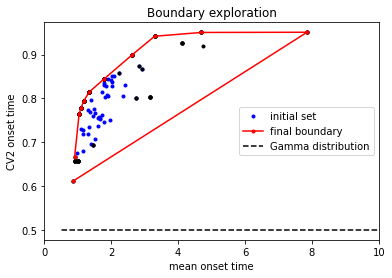

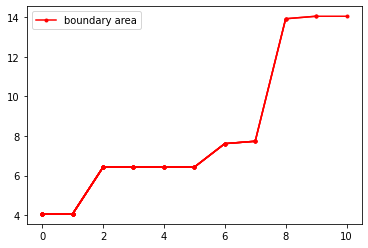

In [135]:
#Testing the boundary exploration
n_initial = 50
iterations = 10
slices = 10
n_states = 3
s = 0.5
k_start = 2
k_min = 0
k_max = 4
mean_max = 10
N_cells = 50000
BoundaryExploration(n_initial,iterations,slices,n_states,s,k_start,k_min,k_max,mean_max,N_cells)

Interestingly, it looks like the boundary algorithm is having trouble exploring the parameter space. We know from sensitivity explorations that the general model should be able to smoothly explore the area around the Gamma distribution limit, but the exploration algorithm seems to be restricted to the upper left quadrant.

Testing the algorithm with a super naive function (e.g. treating the diagonals of a 2x2 matrix as x and y coordinates) indicates the exploration algorithm itself works. So the issue is something with how the parameter space of the Markov chain model gets explored. My hunch is that the stochastic nature of the simulation is interfering with determining the "smoothness" of the underlying feature space.